In [1]:
#import packages
import time
import requests
import sys
import pandas as pd
from Bio import AlignIO
from pymsaviz import MsaViz
import plotly.express as px

In [2]:
 #functions utilized

#requests function
def get_url(url, **kwargs):
    response = requests.get(url, **kwargs)
    if not response.ok:
        print(response.text)
        response.raise_for_status()
        sys.exit()

    return response


#check the status of the alignment job
def status_check():
    if job_status.text == 'RUNNING' or job_status.text == 'QUEUED':
        print(job_status.text)
        return True
    else:
        print('FINISHED')
        return False


#show the alignment once job has completed
def show_alignment():
    query_alignment = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id}/aln-clustal_num")
    print(query_alignment.text)
    

#turn MSA file into fasta file using BioPython
def convert_clustal_to_fasta(input_file, output_file):
    #parse the CLUSTAL file and read the alignment
    clustal_alignment = AlignIO.read(input_file, "clustal")

    #write the alignment in FASTA format
    with open(output_file, "w") as fasta_file:
        AlignIO.write(clustal_alignment, fasta_file, "fasta")

    
def aln_site_identity_df(aln, characters="ACDEFGHIKLMNPQRSTVWY"):
  aln_rows = aln.get_alignment_length()
  comp_dict = {char:[0]*aln_rows for char in characters}
  for record in aln:
    seq = record.seq
    for aaPos in range(len(seq)):
      aa = seq[aaPos]
      if aa in characters:
          comp_dict[aa][aaPos] += 1
                
  return pd.DataFrame.from_dict(comp_dict)


def aln_site_conservation_df(aln):
    aln_rows = aln.get_alignment_length()
    comp_dict = {char: [0] * aln_rows for char in aa_list}
    for record in aln:
        seq = record.seq
        for aa_pos in range(len(seq)):
            aa = seq[aa_pos]
            if aa in aa_list[0]:
                comp_dict['RHK'][aa_pos] += 1
            elif aa in aa_list[1]:
                comp_dict['DE'][aa_pos] += 1
            elif aa in aa_list[2]:
                comp_dict['STNQ'][aa_pos] += 1
            elif aa in aa_list[3]:
                comp_dict['AVILMNFYW'][aa_pos] += 1
            elif aa in aa_list[4]:
                comp_dict['CGP'][aa_pos] += 1
                
    return pd.DataFrame.from_dict(comp_dict)

In [3]:
#constants
UNIPROT_ENDPOINT = 'https://rest.uniprot.org'
QUERY = input("Enter the gene name").lower()
EXPECTED_LENGTH = int(input("Enter the expected length of the protein"))
MIN_SEQ_LENGTH = EXPECTED_LENGTH - (EXPECTED_LENGTH * 0.05)

In [4]:
#read and convert taxonomy csv to a dictionary
df = pd.read_csv('species_dataset.csv',
                 usecols=['Taxon Id', 'Common name', 'Scientific name'])

result = df.to_dict(orient='records')

In [5]:
#create new dictionary of only scientific name and taxon ID
taxon_id_list = []
scientific_name_list = []

for ids in result:
    for key in ids:
        if key == 'Taxon Id':
            taxon_id = ids[key]
            taxon_id_list.append(taxon_id)
        if key == 'Scientific name':
            scientific_name = ids[key]
            scientific_name_list.append(scientific_name)

taxonomy_dict = dict(zip(scientific_name_list, taxon_id_list))

In [29]:
#create an accession list which will be used to query and retrieve sequences
accession_list = []
accession_dict = {}
hits = 0
exceptions = 0
fail = 0
search_number = 0
no_results = 0

for tax_id in taxonomy_dict.values():
    r = get_url(f"{UNIPROT_ENDPOINT}/uniprotkb/search?query={QUERY} AND (taxonomy_id: {tax_id})")
    data = r.json()
    
    search_number += 1
    n_results = len(data["results"])
    if n_results != 0:
        # print(f"Number of results: {n_results}\n")
        for sequences in data['results']:
            protein_existence = sequences['proteinExistence']
            
            if (protein_existence == '1: Evidence at protein level' or
                    protein_existence == '2: Evidence at transcript level' or
                    protein_existence == '3: Inferred from homology'):
    
                try:
                    seq_len = int(sequences['sequence']['length'])
                    gene_name = (sequences['genes'][0]['geneName']['value']).lower()
                    
                    if QUERY in gene_name:
                
                        if seq_len >= MIN_SEQ_LENGTH:
                            accession_id = sequences['primaryAccession']
                            sequence = sequences['sequence']
                            accession_dict[accession_id] = sequence
                            accession_list.append(sequences['primaryAccession'])
                            hits += 1
                            print(f'Hits: {hits}, Exceptions: {exceptions}, Fail: {fail}, '
                               f'No Results: {no_results}, Search Number: {search_number}')
                            break
                    
                except KeyError:
                    exceptions += 1
                    print(f'Hits: {hits}, Exceptions: {exceptions}, Fail: {fail}, '
                               f'No Results: {no_results}, Search Number: {search_number}')
                    break
                
                fail += 1
                print(f'Hits: {hits}, Exceptions: {exceptions}, Fail: {fail}, '
                               f'No Results: {no_results}, Search Number: {search_number}')
            else:   
                fail += 1
                print(f'Hits: {hits}, Exceptions: {exceptions}, Fail: {fail}, '
                               f'No Results: {no_results}, Search Number: {search_number}')
    else:
        no_results += 1
        print(f'Hits: {hits}, Exceptions: {exceptions}, Fail: {fail}, '
                               f'No Results: {no_results}, Search Number: {search_number}')
print(accession_list)

Hits: 1, Exceptions: 0, Fail: 0, No Results: 0, Search Number: 1
Hits: 1, Exceptions: 0, Fail: 0, No Results: 1, Search Number: 2
Hits: 1, Exceptions: 0, Fail: 0, No Results: 2, Search Number: 3
Hits: 1, Exceptions: 0, Fail: 0, No Results: 3, Search Number: 4
Hits: 1, Exceptions: 0, Fail: 0, No Results: 4, Search Number: 5
Hits: 1, Exceptions: 0, Fail: 0, No Results: 5, Search Number: 6
Hits: 1, Exceptions: 0, Fail: 0, No Results: 6, Search Number: 7
Hits: 1, Exceptions: 0, Fail: 0, No Results: 7, Search Number: 8
Hits: 2, Exceptions: 0, Fail: 0, No Results: 7, Search Number: 9
Hits: 3, Exceptions: 0, Fail: 0, No Results: 7, Search Number: 10
Hits: 4, Exceptions: 0, Fail: 0, No Results: 7, Search Number: 11
Hits: 4, Exceptions: 0, Fail: 0, No Results: 8, Search Number: 12
Hits: 4, Exceptions: 0, Fail: 0, No Results: 9, Search Number: 13
Hits: 4, Exceptions: 0, Fail: 0, No Results: 10, Search Number: 14
Hits: 4, Exceptions: 0, Fail: 0, No Results: 11, Search Number: 15
Hits: 5, Exceptio

In [31]:
#join the list and create a fasta
joined = ','.join(accession_list)
align_response = get_url(f"{UNIPROT_ENDPOINT}/uniprotkb/accessions?accessions={joined}&format=fasta")
fasta = align_response.text
with open(f'{QUERY}_unaligned.fasta', 'w+') as file:
    file.writelines(fasta)
print(fasta)

<class 'str'>
>tr|A0A2K5S9X7|A0A2K5S9X7_CEBIM Growth/differentiation factor 8 OS=Cebus imitator OX=2715852 GN=MSTN PE=3 SV=1
MQKLQLYVYIYLFMLIVAGSVDLNENSEHNENVEKEGLCNTCTWRQNTKSSRIEAIKIQI
LSKLRLETAPNISKDAIRQLLPKAPPLRELIDQYDVQRDDSSDGSLEDDDYHATTETIIT
MPTESDFLTQADGKPKCCFFKFSSKIQYNKVVKAQLWIYLKPVKTPTTVFVQILRLIKPM
KDGTRYTGIRSLKLDMNPGTGIWQSIDVKTVLQNWLKQPESNLGIEIKALDDNGHDLAVT
FPESKENGLNPFLEVKVTDTPKRSRRDFGLDCDDLSTETRCCRYPLTVDFEAFGWDWIIA
PKRYKANYCSGECDFVFLQKYPHTHLVHQANPKGSAGPCCTPTKMSPINMLYFNGKEQII
YGKIPAMVVDRCGCS
>tr|A0A2K6JS16|A0A2K6JS16_RHIBE Growth/differentiation factor 8 OS=Rhinopithecus bieti OX=61621 GN=MSTN PE=3 SV=1
IMQKLQLCVYIYLFMLIVAGPVDLNENSEQKENVEKEGLCNACTWRQNTKSSRIEAIKIQ
ILSKLRLETAPNISKDAIRQLLPKAPPLRELIDQYDVQRDDSSDGSLEDDDYHATTETII
TMPTESDFLMRMDGKPKCCFFKFSSKIQYNKVVKAQLWIYLRPVETPTTVFVQILRLIKP
MKDGTRYTGIRSLKLDMNPGTGIWQSIDVKTVLQNWLKQPESNLGIEIKALDENGHDLAV
TFPGPGEDGLNPFLEVKVTDTPKRSRRDFGLDCDEHSTESRCCRYPLTVDFEAFGWDWII
APKRYKANYCSGECEFVFLQKYPHTHLVHQANPRGSAGPCCTPTKMSPINMLYFNGKEQI
IYGKIPAMVVDRC

In [8]:
#submit and monitor job status
response_alignment = requests.post("https://www.ebi.ac.uk/Tools/services/rest/clustalo/run", data={
    "email": "example@example.com",
    "iterations": 0,
    "outfmt": "clustal_num",
    "order": "aligned",
    "sequence": fasta
})

job_id = response_alignment.text
job_status = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id}")

while status_check():
    job_status = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id}")
    time.sleep(3)

QUEUED
RUNNING
RUNNING
FINISHED


In [9]:
#show alignment
show_alignment()

CLUSTAL O(1.2.4) multiple sequence alignment


tr|A0A3B3HAX7|A0A3B3HAX7_ORYLA      MISIRVAHLSKHGYLRIRSTLPQR-------IFVFFFK----KKSQTNKQNKRHTSETMD	49
tr|E7DX60|E7DX60_TAKRU              ----------------------------------------------------------MQ	2
tr|A0A165G1F9|A0A165G1F9_ORENI      ----------------------------------------------------------MH	2
sp|O42222|GDF8_DANRE                ----------------------------------------------------------MH	2
tr|A0A8B9K751|A0A8B9K751_ASTMX      ----------------------------------------------------------MH	2
tr|H3B5H6|H3B5H6_LATCH              ----------------------------------------------------------MQ	2
tr|A0A6I8PB41|A0A6I8PB41_ORNAN      ------------------------------------MG------------PGSGRGRGRG	12
tr|A0A803JZQ6|A0A803JZQ6_XENTR      ----------------------------------------------------------MI	2
tr|A0A1L8EQ37|A0A1L8EQ37_XENLA      ----------------------------------------------------------MN	2
tr|G1KCN0|G1KCN0_ANOCA              ------------------------

In [10]:
#create alignment file
alignment = (get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id}/aln-clustal_num")).text

with open(f'{QUERY}_aligned_MSA.aln', 'w+') as file:
    file.writelines(alignment)

In [11]:
#turn MSA file into fasta file using BioPython
input_clustal_file = f"{QUERY}_aligned_MSA.aln"
output_fasta_file = f"{QUERY}_aligned_fasta.fasta"

convert_clustal_to_fasta(input_clustal_file, output_fasta_file)

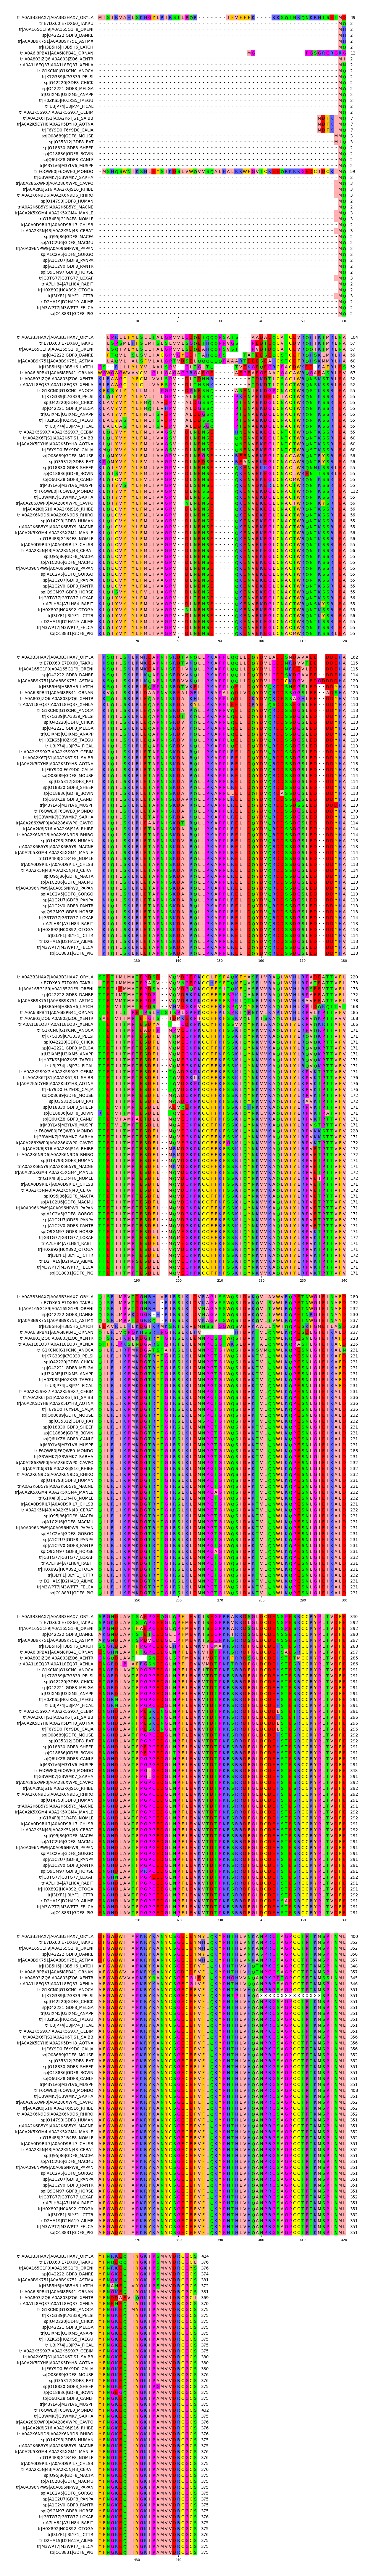

In [12]:
#Generate multiple sequence alignment image
msa_file = open(f"{QUERY}_aligned_fasta.fasta")
mv = MsaViz(msa_file, wrap_length=60, show_count=True)
mv.savefig(f"{QUERY}.png")

In [13]:
#Load alignment data
alignment_file = f"{QUERY}_aligned_MSA.aln"
query_align = AlignIO.read(alignment_file, "clustal")
print(query_align)

Alignment with 51 rows and 444 columns
MISIRVAHLSKHGYLRIRSTLPQR-------IFVFFFK----KK...GCS tr|A0A3B3HAX7|A0A3B3HAX7_ORYLA
--------------------------------------------...GCL tr|E7DX60|E7DX60_TAKRU
--------------------------------------------...GYS tr|A0A165G1F9|A0A165G1F9_ORENI
--------------------------------------------...GCS sp|O42222|GDF8_DANRE
--------------------------------------------...GCS tr|A0A8B9K751|A0A8B9K751_ASTMX
--------------------------------------------...GCS tr|H3B5H6|H3B5H6_LATCH
------------------------------------MG------...GCS tr|A0A6I8PB41|A0A6I8PB41_ORNAN
--------------------------------------------...GCI tr|A0A803JZQ6|A0A803JZQ6_XENTR
--------------------------------------------...GCS tr|A0A1L8EQ37|A0A1L8EQ37_XENLA
--------------------------------------------...GCS tr|G1KCN0|G1KCN0_ANOCA
--------------------------------------------...GCS tr|K7G339|K7G339_PELSI
--------------------------------------------...GCS sp|O42220|GDF8_CHICK
-----------------------------

In [14]:
#Create alignment data frame
alignment_site_identity_df = aln_site_identity_df(query_align)
alignment_site_identity_df

A   C  D  E  F   G  H  I  K  L  M  N  P  Q   R   S  T  V  W  Y
0    0   0  0  0  0   0  0  0  0  0  1  0  0  0   0   0  0  0  0  0
1    0   0  0  0  0   0  0  1  0  0  1  0  0  0   0   0  0  0  0  0
2    0   0  0  0  0   0  0  0  0  0  0  0  0  0   0   2  0  0  0  0
3    0   0  0  0  0   0  1  1  0  0  0  0  0  0   0   0  0  0  0  0
4    0   0  0  0  0   0  0  0  0  0  0  0  0  1   1   0  0  0  0  0
..  ..  .. .. .. ..  .. .. .. .. .. .. .. .. ..  ..  .. .. .. .. ..
439  0   0  0  0  0   0  0  0  0  0  0  0  0  0  51   0  0  0  0  0
440  0  51  0  0  0   0  0  0  0  0  0  0  0  0   0   0  0  0  0  0
441  0   0  0  0  0  51  0  0  0  0  0  0  0  0   0   0  0  0  0  0
442  0  50  0  0  0   0  0  0  0  0  0  0  0  0   0   0  0  0  0  1
443  0   0  0  0  0   0  0  1  0  1  0  0  0  0   0  49  0  0  0  0

[444 rows x 20 columns]

In [15]:
#Normalize data frame
normalized_freq_df = alignment_site_identity_df.div(alignment_site_identity_df.sum(axis=1), axis=0)
normalized_freq_df

A         C    D    E    F    G    H         I    K         L    M  \
0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  1.0   
1    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.500000  0.0  0.000000  0.5   
2    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
3    0.0  0.000000  0.0  0.0  0.0  0.0  0.5  0.500000  0.0  0.000000  0.0   
4    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
..   ...       ...  ...  ...  ...  ...  ...       ...  ...       ...  ...   
439  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
440  0.0  1.000000  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
441  0.0  0.000000  0.0  0.0  0.0  1.0  0.0  0.000000  0.0  0.000000  0.0   
442  0.0  0.980392  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.000000  0.0   
443  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.019608  0.0  0.019608  0.0   

       N    P    Q    R         S    T    V    W         Y  
0    0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  
1    0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  
2    0.0  0.0  0.0  0.0  1.000000  0.0  0.0  0.0  0.000000  
3    0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  
4    0.0  0.0  0.5  0.5  0.000000  0.0  0.0  0.0  0.000000  
..   ...  ...  ...  ...       ...  ...  ...  ...       ...  
439  0.0  0.0  0.0  1.0  0.000000  0.0  0.0  0.0  0.000000  
440  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  
441  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  
442  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.019608  
443  0.0  0.0  0.0  0.0  0.960784  0.0  0.0  0.0  0.000000  

[444 rows x 20 columns]

In [16]:
#Plot sequence identity 
fig = px.bar(normalized_freq_df, y=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], title="identity")

fig.update_layout(
    xaxis = dict(
        rangeslider = dict(
            visible=True
        )
    )
)

fig.show()

In [20]:
#Generate and plot amino acid conservation
aa_list = ['RHK', 'DE', 'STNQ', 'AVILMNFYW', 'CGP']

#create alignment data frame 
alignment_site_identity_df = aln_site_conservation_df(query_align)
alignment_site_identity_df

RHK  DE  STNQ  AVILMNFYW  CGP
0      0   0     0          1    0
1      0   0     0          2    0
2      0   0     2          0    0
3      1   0     0          1    0
4      1   0     1          0    0
..   ...  ..   ...        ...  ...
439   51   0     0          0    0
440    0   0     0          0   51
441    0   0     0          0   51
442    0   0     0          1   50
443    0   0    49          2    0

[444 rows x 5 columns]

In [18]:
#Normalize the data frame
normalized_conservation_freq_df = alignment_site_identity_df.div(
    alignment_site_identity_df.sum(axis=1), axis=0)
normalized_conservation_freq_df

RHK   DE      STNQ  AVILMNFYW       CGP
0    0.0  0.0  0.000000   1.000000  0.000000
1    0.0  0.0  0.000000   1.000000  0.000000
2    0.0  0.0  1.000000   0.000000  0.000000
3    0.5  0.0  0.000000   0.500000  0.000000
4    0.5  0.0  0.500000   0.000000  0.000000
..   ...  ...       ...        ...       ...
439  1.0  0.0  0.000000   0.000000  0.000000
440  0.0  0.0  0.000000   0.000000  1.000000
441  0.0  0.0  0.000000   0.000000  1.000000
442  0.0  0.0  0.000000   0.019608  0.980392
443  0.0  0.0  0.960784   0.039216  0.000000

[444 rows x 5 columns]

In [19]:
#Plot percent conservation 
fig = px.bar(normalized_conservation_freq_df, 
             y=['RHK', 'DE', 'STNQ', 'AVILMNFYW', 'CGP'], title="conservation")

fig.update_layout(
    xaxis = dict(
        rangeslider = dict(
            visible=True
        )
    )
)


fig.show()